In [ ]:
import random
import numpy as np
import matplotlib as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso 
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.metrics import mean_squared_error
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


### Пример переобучения

Подготовим данные для демонстрации переобучения на них. Сгенерируем тренировочную и тестовую выборку с помощью линейной функции с нормальным шумом. 

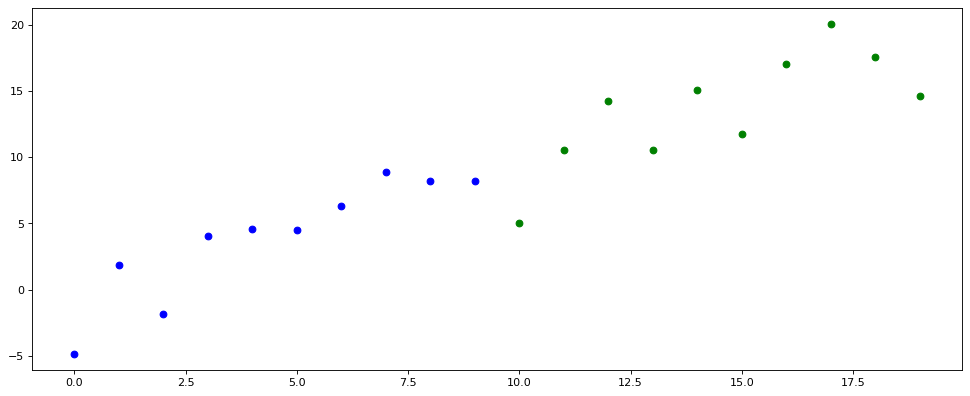

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)

# параметры выборки - размер и дисперсия шума
TRAIN_SET = 10
TEST_SET = 10
VARIANCE = 0.5

#генерация тренировочной выборки
x_train = np.array([i for i in range(TRAIN_SET)])
y_train = np.array([(x + 5 * np.random.normal(0,VARIANCE)) for x in x_train])

#генерация тестовой выборки
x_test = np.array([i for i in range(TRAIN_SET,TRAIN_SET + TEST_SET)])
y_test = np.array([(x + 5 * np.random.normal(0,VARIANCE)) for x in x_test])

plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

In [ ]:
def poly_experiment_train(X_train, Y_train, nb_degree, model):
    """
    функция обучения для полиномиальной регрессии
    """
    # преобразование независимой переменной в количество признаков равному степени полинома
    polynomial_features = PolynomialFeatures(degree = nb_degree)
    X_TRANSF = polynomial_features.fit_transform(X_train.reshape(-1,1))
    #обучение линейной регрессии
    model.fit(X_TRANSF, Y_train)
    #оценка на обучающей выборке
    Y_NEW = model.predict(X_TRANSF)
    mse = mean_squared_error(Y_train, Y_NEW)
    return {"transformer": polynomial_features,
            "model": model,
            "prediction": Y_NEW,
            'error': mse}

def poly_experiment_test(X_test, Y_test, transformer, model):
    """
    функция предсказания на тестовой выборке. На вход обученный преобразователь в полином(transformer)
    и модель с подобранными весами.
    """
    X_TRANSF = transformer.transform(X_test.reshape(-1,1))
    Y_NEW = model.predict(X_TRANSF)
    mse = mean_squared_error(Y_test, Y_NEW)
    return {"prediction": Y_NEW, 'error': mse}

(-10.0, 30.044581038666593)

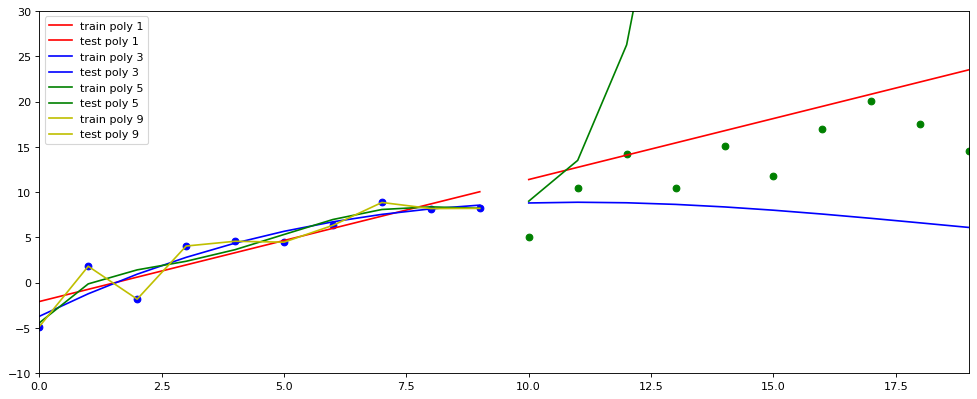

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)


models_coefs = []

test_mse_list = []

# рассмотрим полиномы соответсвующих степеней и определим цвета их графиков
degree_dict = {
    1: 'r',
    3: 'b',
    5: 'g',
    9: 'y',
}
for degree in degree_dict:
    # инициализируем модель
    model = LinearRegression()
    # предсказания на обучающей выборке
    train_pred = poly_experiment_train(x_train, y_train, degree, model)
    plt.plot(x_train, train_pred['prediction'], label = f'train poly {degree}', color=degree_dict[degree])
    
    #предсказания на тестовой выборке
    test_pred = poly_experiment_test(x_test, y_test, train_pred['transformer'], train_pred['model'])
    plt.plot(x_test, test_pred['prediction'], label = f'test poly {degree}', color=degree_dict[degree])
    
    test_mse_list.append(test_pred['error'])
    models_coefs.append(train_pred['model'].coef_)
    
    
# визуализация обучения
plt.legend(loc='best')

plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

plt.xlim(x_train[0], x_test[-1])
plt.ylim(np.min(x_train) - 10, np.max(y_test) + 10) 

In [ ]:
# выведем ошибки полиномов на тестовой выборке
for key, error in zip(list(degree_dict.keys()), test_mse_list):
    print(f"poly {key} - {error}")

poly 1 - 22.212018019474538
poly 3 - 55.66242656985613
poly 5 - 268979.6508966376
poly 9 - 7009333008061.125


In [ ]:
#посмотрим на коэфициенты обученных моделей
for key, coefs in zip(list(degree_dict.keys()), models_coefs):
    print(f"poly {key} :", coefs)
    print()

poly 1 : [0.         1.34811495]

poly 3 : [ 0.          2.66001559 -0.17176545  0.00310329]

poly 5 : [ 0.00000000e+00  6.79904683e+00 -3.18744632e+00  7.79483230e-01
 -8.27936804e-02  3.12659699e-03]

poly 9 : [ 0.00000000e+00  9.33983876e+01 -1.93352349e+02  1.63139704e+02
 -7.29150593e+01  1.92128204e+01 -3.09680741e+00  3.00960418e-01
 -1.62254512e-02  3.73087149e-04]



#### Regularization

Воспользуемся регрессиями с регуляризацией - Lasso и Ridge. Посмотрим, как в обоих случаях влияет регуляризация на ошибку на тестовой выборке. 

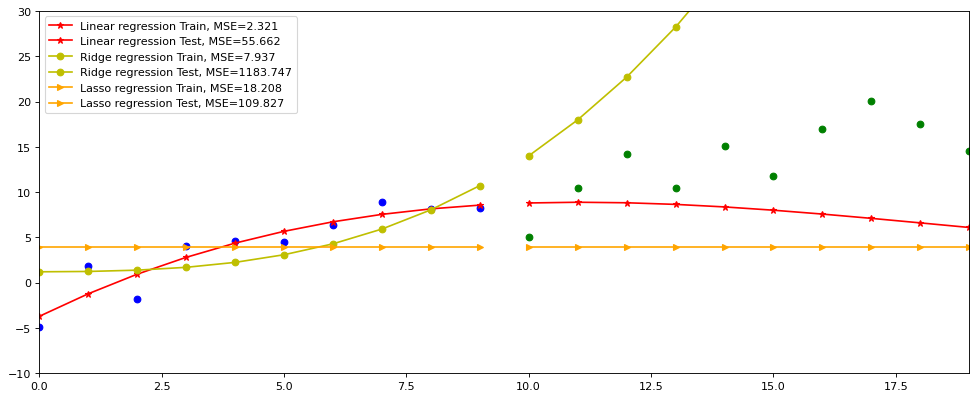

In [ ]:
#linear regression
plt.figure(figsize=(15, 6), dpi=80)
plt.scatter(x_train, y_train, color='b')
plt.scatter(x_test, y_test, color='g')

# для моделирования возьмем полином 4 степени
DEGREE = 3
# коэфициент регуляризации
ALPHA_SIZE = 5000

#обучим обычную линейную регрессию и версии с регуляризацией


lin_model = LinearRegression()
lin_train = poly_experiment_train(x_train, y_train, DEGREE, lin_model)
plt.plot(x_train, lin_train['prediction'], '*-', label = f"Linear regression Train, MSE={round(lin_train['error'], 3)}", color='r')

lin_test = poly_experiment_test(x_test, y_test, lin_train['transformer'], lin_train['model'])
plt.plot(x_test, lin_test['prediction'], '*-', label = f"Linear regression Test, MSE={round(lin_test['error'], 3)}", color='r')

ridge_model = Ridge(alpha=ALPHA_SIZE)
ridge_train = poly_experiment_train(x_train, y_train, DEGREE, ridge_model)
plt.plot(x_train, ridge_train['prediction'], 'o-' ,label = f"Ridge regression Train, MSE={round(ridge_train['error'], 3)}", color='y')

ridge_test = poly_experiment_test(x_test, y_test, ridge_train['transformer'], ridge_train['model'])
plt.plot(x_test, ridge_test['prediction'], 'o-', label = f"Ridge regression Test, MSE={round(ridge_test['error'], 3)}", color='y')

lasso_model = Lasso(alpha=ALPHA_SIZE)
lasso_train = poly_experiment_train(x_train, y_train, DEGREE, lasso_model)
plt.plot(x_train, lasso_train['prediction'], '>-', label = f"Lasso regression Train, MSE={round(lasso_train['error'], 3)}", color='orange')

lasso_test = poly_experiment_test(x_test, y_test, lasso_train['transformer'], lasso_train['model'])
plt.plot(x_test, lasso_test['prediction'], '>-' ,label = f"Lasso regression Test, MSE={round(lasso_test['error'], 3)}", color='orange')

#посмотрим на графике, как меняется предсказание на тестовой выборке в зависимости от типа модели

plt.legend(loc='best')
plt.xlim(x_train[0], x_test[-1])
plt.ylim(np.min(x_train) - 10, np.max(y_test) + 10) 

plt.savefig('regularization_example.png')

/var/folders/hg/wyjbzhnn71d60tgsx5l8yt1c0000gn/T/ipykernel_54726/1901718561.py:18: RuntimeWarning: divide by zero encountered in log
  ax1.plot(np.log(ALPHA_LIST), coefs_list)
/var/folders/hg/wyjbzhnn71d60tgsx5l8yt1c0000gn/T/ipykernel_54726/1901718561.py:23: RuntimeWarning: divide by zero encountered in log
  ax2.plot(np.log(ALPHA_LIST), error_list)


Text(0.5, 1.0, 'Влияние регуляризации на ошибку модели')

<Figure size 1200x480 with 0 Axes>

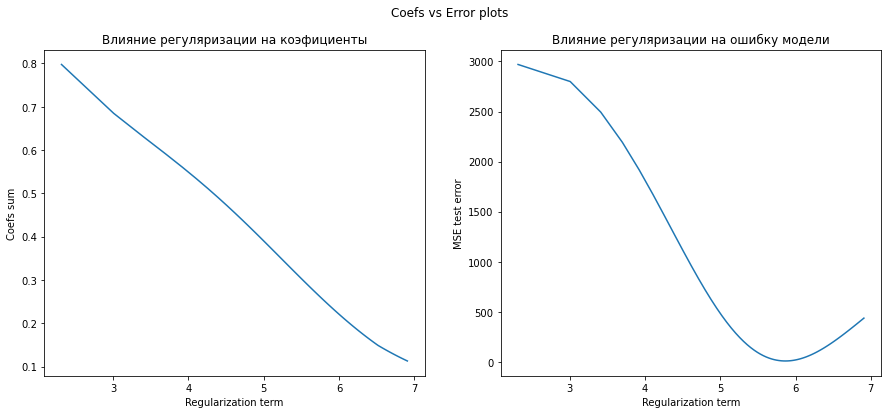

In [ ]:
plt.figure(figsize=(15, 6), dpi=80)

ALPHA_LIST = np.linspace(0,1000, 100)

coefs_list, error_list = [], []
#посмотрим на коэффициенты модели и ошибку на тестовой выборке при разных параметрах регуляризации
for alpha in ALPHA_LIST:
    ridge_model = Ridge(alpha=alpha)
    ridge_train = poly_experiment_train(x_train, y_train, DEGREE, ridge_model)
    ridge_test = poly_experiment_test(x_test, y_test, ridge_train['transformer'], ridge_train['model'])
    coefs_list.append(sum(np.abs(ridge_train['model'].coef_)))
    error_list.append(ridge_test['error'])

    
# построим графики зависимости
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

fig.suptitle('Coefs vs Error plots')

ax1.plot(np.log(ALPHA_LIST), coefs_list)
ax1.set_xlabel('Regularization term')
ax1.set_ylabel('Coefs sum')
ax1.set_title('Влияние регуляризации на коэфициенты')

ax2.plot(np.log(ALPHA_LIST), error_list)
ax2.set_xlabel('Regularization term')
ax2.set_ylabel('MSE test error')
ax2.set_title('Влияние регуляризации на ошибку модели')

In [ ]:
# найдем коэфициент регуляризации, при котором ошибка на тестовой выборке мнимальна
ALPHA_LIST[np.argmin(error_list)]

353.5353535353535